<a href="https://colab.research.google.com/github/ZarmelZar/comp215/blob/main/labs/lab05_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 5
----------------
#### Name(s): Melika Mousavikhah
#### Date: 2025/02/05

By the end of this lab you should be able to:
  * apply both a direct (ie. brute force) and heuristic algorithm to a problem
  * use the networkx module to visualize graphs
  * measure algorithm scaling


During this lab, you will be introduced to the following:
  * seeding the random module



## The Traveling Salesperson Problem

This lab is based on the famous Traveling Salesperson Problem (TSP) outlined in Section 3.3.2 of 'On Complexity'.  Imagine you needed to travel to ten different cities.  What is the sortest possible route you could take to visit every city?  For our version of the problem, you start from a specific city and must end on the same city.

In this lab, you will implement a direct (ie. brute force) and a heuristic solution to the problem.

In [54]:
# start with some imports
import random, math, time, itertools
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

## Set up the map

For this implementation of the problem we will randomly place N cities on a 100 by 100 grid.  Cities will be labelled using a single character; 'A', 'B', 'C', etc.  City locations will be denoted by a 2-tuple, `(x,y)`, giving their position on the grid. In order to create reproducable maps, we will use [random.seed()](https://docs.python.org/3/library/random.html#random.seed) to initialize the random module.  

In [62]:
def setup_map(N, seed=1):
  ''' Returns a map of N cities with random locations on a 100 by 100 grid '''
  random.seed(seed)
  city_locations = [(random.randint(0, 100), random.randint(0, 100)) for i in range(N)]
  city_names = [chr(65 + i) for i in range(N)]
  city_map = dict(zip(city_names, city_locations))
  return city_map, dict(zip(city_names, city_locations))

def graph_map(city_map):
  ''' graph the map of cities using networkx'''
  G = nx.Graph()
  G.add_nodes_from(city_map)
  nx.draw(G, city_map, with_labels=True)

def distance(city1, city2, city_map):
  ''' Returns the distance between two cities on a map'''
  x1, y1 = city_map[city1]
  x2, y2 = city_map[city2]
  return round(math.sqrt((x2 - x1)**2 + (y2 - y1)**2),1)

def calculate_distances(city_map):
  ''' Returns a dictionary with the distances between all pairs of cities in a map '''
  distances = {}
  for city1 in city_map:
      for city2 in city_map:
          if city1 != city2:
              # this will have duplicate distances (A,B) and (B,A)
              # these duplicates make the algorithm implememntation simpler
              distances[(city1, city2)] = distance(city1, city2, city_map)
  return distances


City Map: {'A': (17, 72), 'B': (97, 8), 'C': (32, 15), 'D': (63, 97), 'E': (57, 60), 'F': (83, 48), 'G': (100, 26), 'H': (12, 62), 'I': (3, 49), 'J': (55, 77)}
Distances between cities: {('A', 'B'): 102.4, ('A', 'C'): 58.9, ('A', 'D'): 52.4, ('A', 'E'): 41.8, ('A', 'F'): 70.2, ('A', 'G'): 94.9, ('A', 'H'): 11.2, ('A', 'I'): 26.9, ('A', 'J'): 38.3, ('B', 'A'): 102.4, ('B', 'C'): 65.4, ('B', 'D'): 95.3, ('B', 'E'): 65.6, ('B', 'F'): 42.4, ('B', 'G'): 18.2, ('B', 'H'): 100.7, ('B', 'I'): 102.6, ('B', 'J'): 80.8, ('C', 'A'): 58.9, ('C', 'B'): 65.4, ('C', 'D'): 87.7, ('C', 'E'): 51.5, ('C', 'F'): 60.7, ('C', 'G'): 68.9, ('C', 'H'): 51.1, ('C', 'I'): 44.7, ('C', 'J'): 66.1, ('D', 'A'): 52.4, ('D', 'B'): 95.3, ('D', 'C'): 87.7, ('D', 'E'): 37.5, ('D', 'F'): 52.9, ('D', 'G'): 80.1, ('D', 'H'): 61.9, ('D', 'I'): 76.8, ('D', 'J'): 21.5, ('E', 'A'): 41.8, ('E', 'B'): 65.6, ('E', 'C'): 51.5, ('E', 'D'): 37.5, ('E', 'F'): 28.6, ('E', 'G'): 54.8, ('E', 'H'): 45.0, ('E', 'I'): 55.1, ('E', 'J'): 17.1,

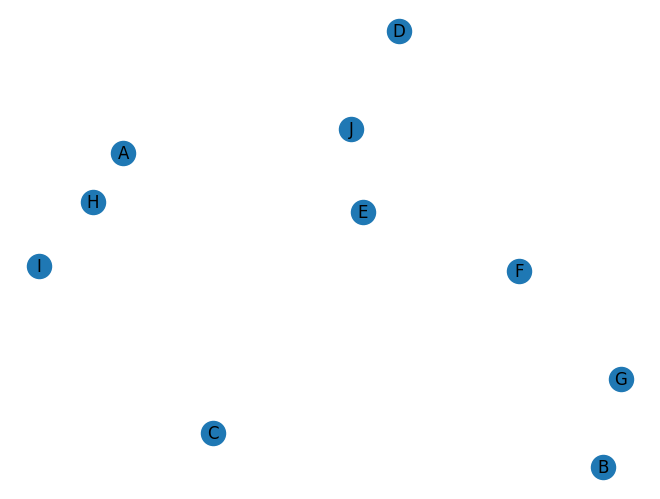

In [56]:
# test our setup functions
city_map = setup_map(10)
print(f'City Map: {city_map}')
distances = calculate_distances(city_map)
print(f'Distances between cities: {distances}')
graph_map(city_map)

### Exercise 1: The Brute Force Solution

Implement a brute force solution to the traveling salesman problem using the city map and distance dictionary given above.  The algorithm for the brute force solution looks something like this:
 1. Loop over every possible route that starts and ends on city A.  For a three city example, this would be ABCA, ACBA.  
 2. Calculate the total distance of each possible route.  
 3. Find the route with the minimum total distance.

Before you start coding, think about what functions and/or class you might want to simplify your implementation of the algorithm.  Write a small test for your algorithm.

In [57]:
def permute(cities):
  if len(cities) == 1:
    return (cities)

  permutations = []
  for i in range(len(cities)):
        rest = cities[:i] + cities[i+1:]
        for perm in permute(rest):
            permutations.append([cities[i]] + list(perm))
  return permutations

def brute_force(city_map, distances):
  cities = list(city_map.keys())
  shortest_route = None
  shortest_distance = float('inf')

  for perm in permute(cities[1:]):
        route = [cities[0]] + perm + [cities[0]]
        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += distances[(route[i], route[i + 1])]
        if total_distance < shortest_distance:
            shortest_distance = total_distance
            shortest_route = route

  return shortest_route, shortest_distance


  #Test
route, distance = brute_force(city_map, distances)
print(f'Shortest route: {route}, Distance: {distance}')

Shortest route: ['A', 'D', 'J', 'E', 'F', 'G', 'B', 'C', 'I', 'H', 'A'], Distance: 302.7


### Exercise 2: Nearest Neighbour

Implement a nearest neighbour solution to the traveling salesman problem using the city map and distance dictionary given above.  The algorithm for the nearest neighbour solution looks something like this:
 1. Start from the starting city.  
 2. Go to the nearest city that has not been visited.  
 3. Repeat steps 1 and 2 until all cities have been visited.

Before you start coding, think about what functions and/or class you might want to simplify your implementation of the algorithm.  Write a small test for your algorithm.

In [58]:
def nearest_neighbour(city_map, distances):
  cities = list(city_map.keys())
  unvisited = set(cities)
  route = [cities[0]]
  unvisited.remove(cities[0])
  total_distance = 0

  current_city = cities[0]

  for i in range(len(cities) - 1):
    nearest_city = []
    minimum_distance = float('inf')

    for city in unvisited:
      distance = distances[current_city, city]
      if distance < minimum_distance:
        nearest_city = city
        minimum_distance = distance


  route.append(nearest_city)
  total_distance += minimum_distance
  current_city = nearest_city
  unvisited.remove(nearest_city)


  total_distance += distances[(current_city, cities[0])]
  route.append(cities[0])

  return route, total_distance

#Test

route, distance = nearest_neighbour(city_map, distances)
print(f'Nearest neighbour route is {route}, and Distance is {distance}.')

Nearest neighbour route is ['A', 'H', 'A'], and Distance is 22.4.


### Exercise 3: Graph the Routes

Use the networkx module to create directed graphs of the routes (brute force and nearest neighbour).  Include the distances between the cities on the edges.  Run several different map setups with a different sizes (ie. number of cities).  Do the brute force (ie. direct) and nearest neighbour (ie. heuristic) algorithms always give the same solution?  Do you notice anything about the brute force solutions that suggests an alternative heuristic algorithm?


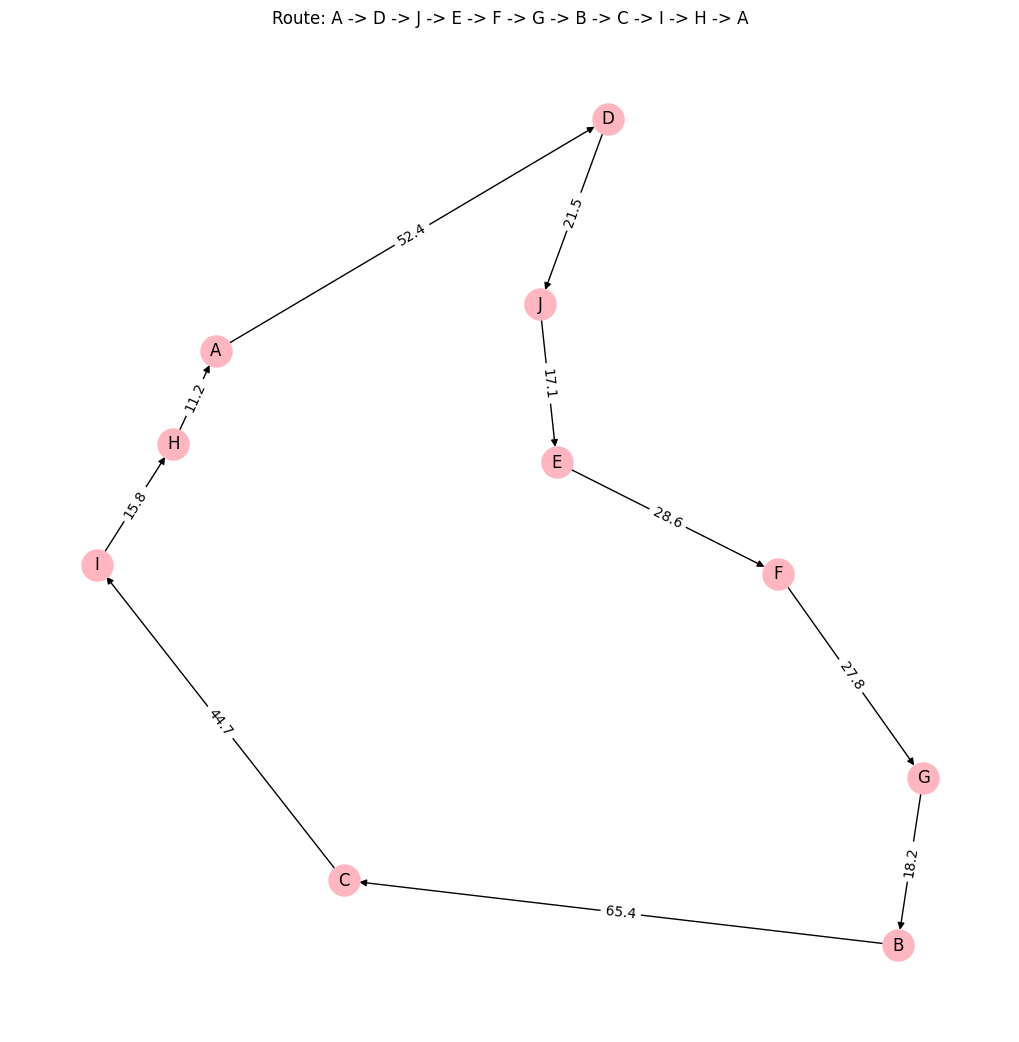

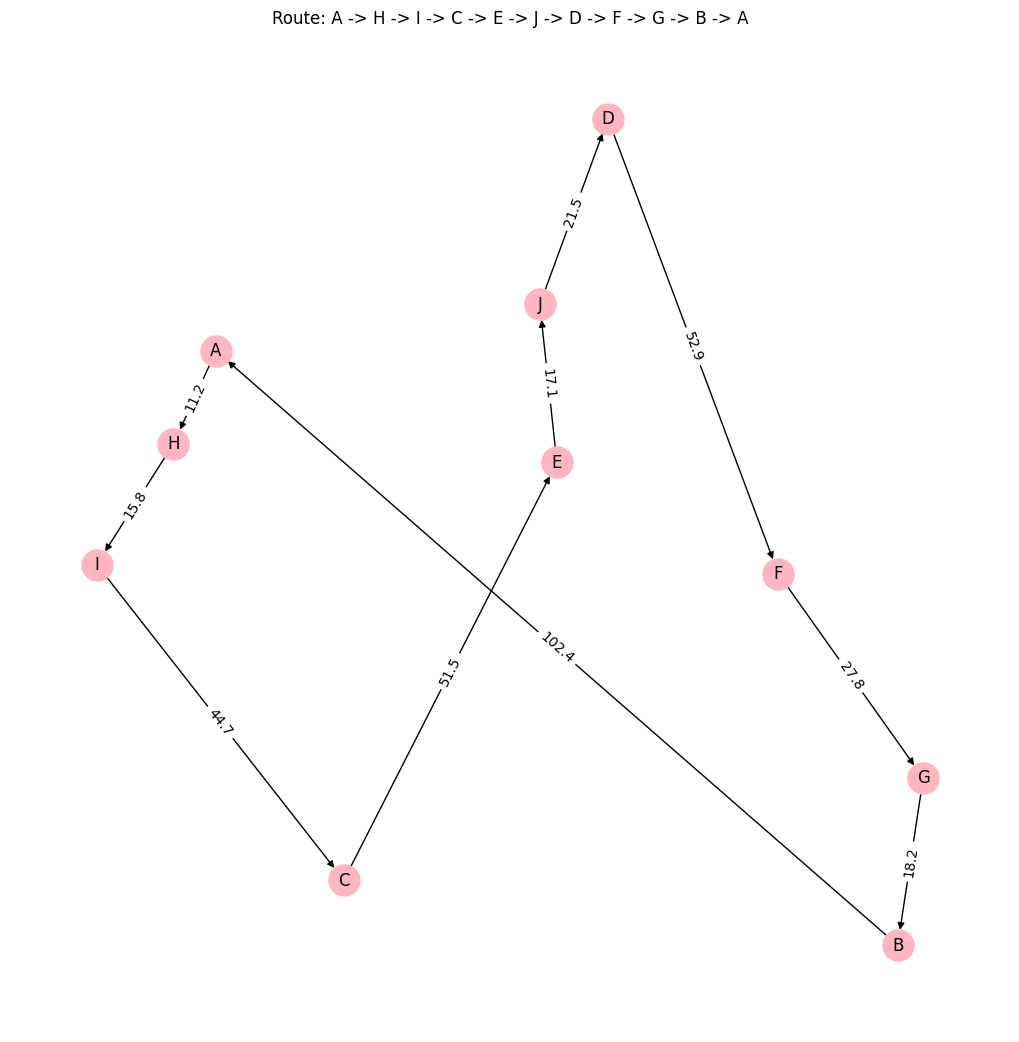

In [69]:
def plot_route(route, city_map):
    G = nx.DiGraph()
    for i in range(len(route) - 1):
        a, b = route[i], route[i+1]
        d = distance(a, b, city_map)
        G.add_edge(a, b, weight=d)
    plt.figure(figsize=(10, 10))
    nx.draw(G, city_map, with_labels=True, node_size=500, node_color='lightpink')
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, city_map, edge_labels=labels)
    plt.title("Route: " + " -> ".join(route))
    plt.show()

#Test

plot_route(bf_route, city_map)
plot_route(nn_route, city_map)

### Exercise 4: Algorithm Scaling

Use the `time` module to measure the running time of the two algorithms.  Note that the `time.time()` function returns the current time, so calling it before and after the algorithm has run can give you the time it takes for the algorithm to execute.  Taking the average over several trials will make the measurement more precise.  Demonstrate the scaling nature of the algorithms by plotting their execution time as a function of N, up to about N = 10.  

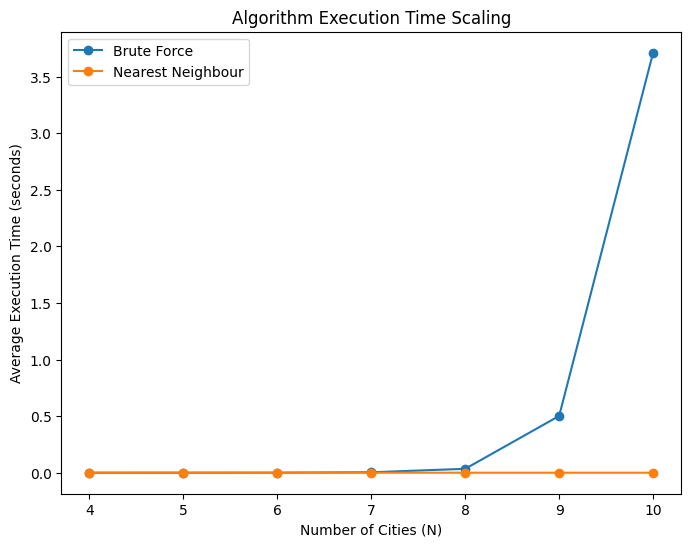

In [71]:
def time_algorithms(max_N=10, trials=3):
    bf_times = {}
    nn_times = {}

    for N in range(4, max_N + 1):
        bf_total, nn_total = 0, 0
        for t in range(trials):
            cm = setup_map(N, seed=t)
            dists = calculate_distances(cm)

            start = time.time()
            brute_force(cm, dists)
            bf_total += time.time() - start

            start = time.time()
            nearest_neighbour(cm, dists)
            nn_total += time.time() - start

        bf_times[N] = bf_total / trials
        nn_times[N] = nn_total / trials

    return bf_times, nn_times

bf_times, nn_times = time_algorithms(max_N=10, trials=3)

plt.figure(figsize=(8, 6))
plt.plot(list(bf_times.keys()), list(bf_times.values()), marker='o', label='Brute Force')
plt.plot(list(nn_times.keys()), list(nn_times.values()), marker='o', label='Nearest Neighbour')
plt.xlabel("Number of Cities (N)")
plt.ylabel("Average Execution Time (seconds)")
plt.title("Algorithm Execution Time Scaling")
plt.legend()
plt.show()